# Прогнозирование уровня средней заработной платы в России

In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


### Считаем данные и построим на графике

In [3]:
#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
wages = pd.read_csv('WAG_C_M.csv',';',index_col=['month'], parse_dates=['month'], dayfirst=True)
wages.WAG_C_M=wages.WAG_C_M
wages.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


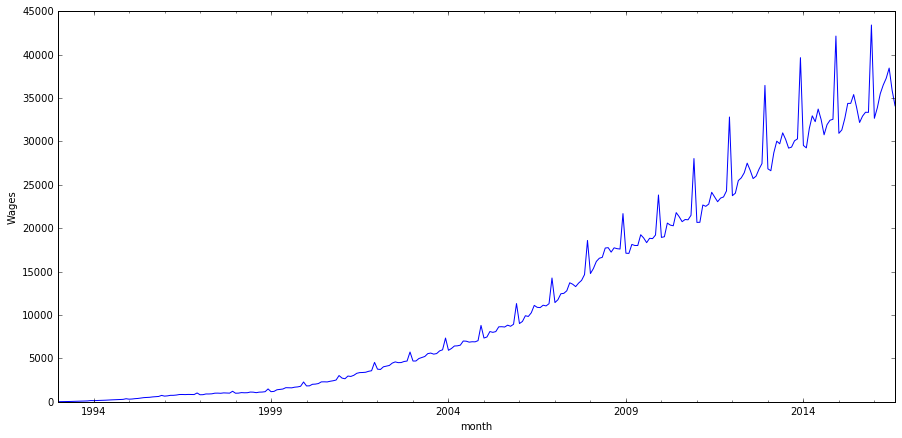

In [4]:
plt.figure(figsize(15,7))
wages.WAG_C_M.plot()
plt.ylabel('Wages')
pylab.show()

### Посмотрим на STL-декомпозицию ряда. Видно, что данные нестационарны, а дисперсия меняется:

Критерий Дики-Фуллера: p=0.991850


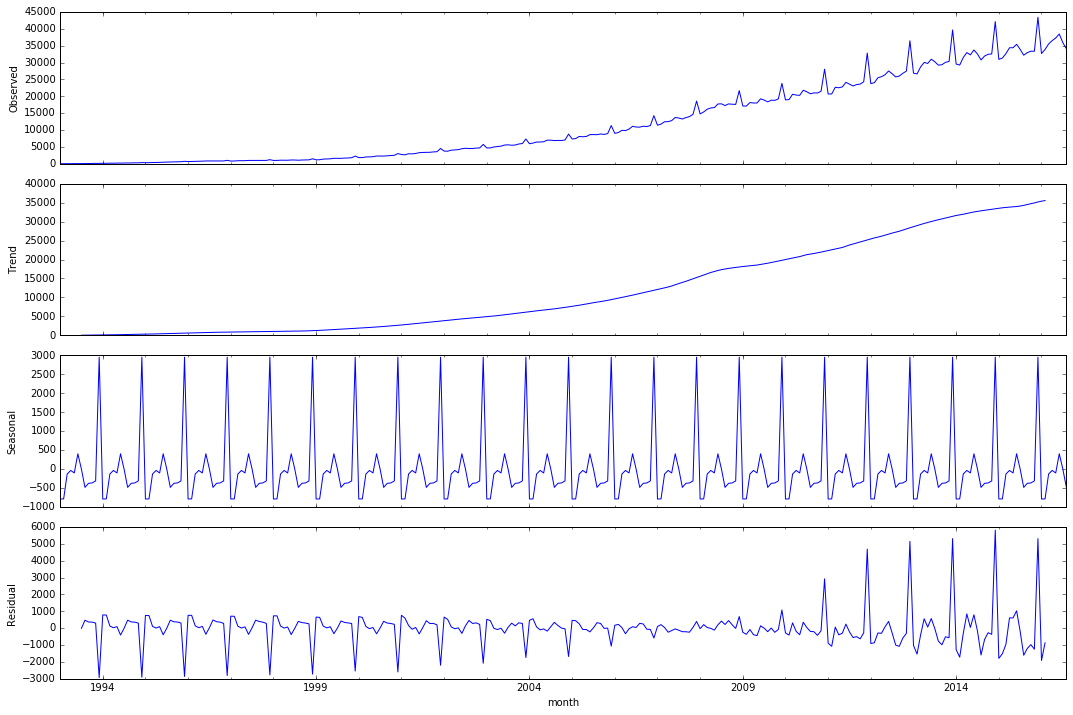

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.WAG_C_M)[1])

## Стабилизация дисперсии
Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


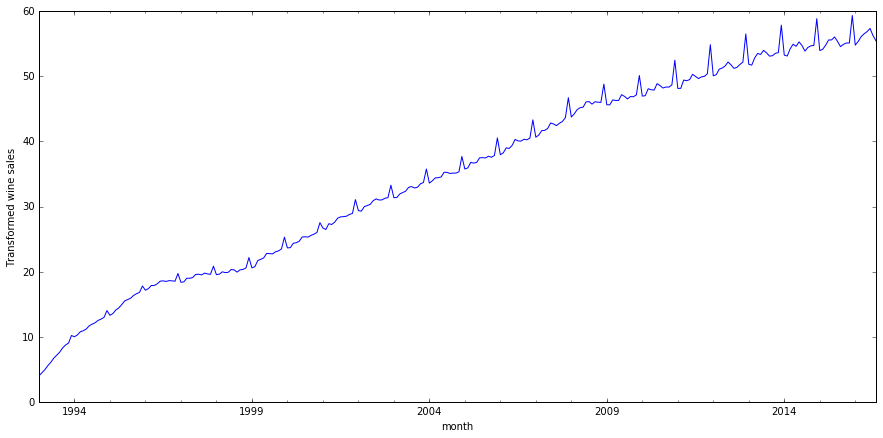

In [6]:
wages['wages_box'], lmbda = stats.boxcox(wages.WAG_C_M)
plt.figure(figsize(15,7))
wages.wages_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages_box)[1])

## Стационарность
## Сначала проведем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


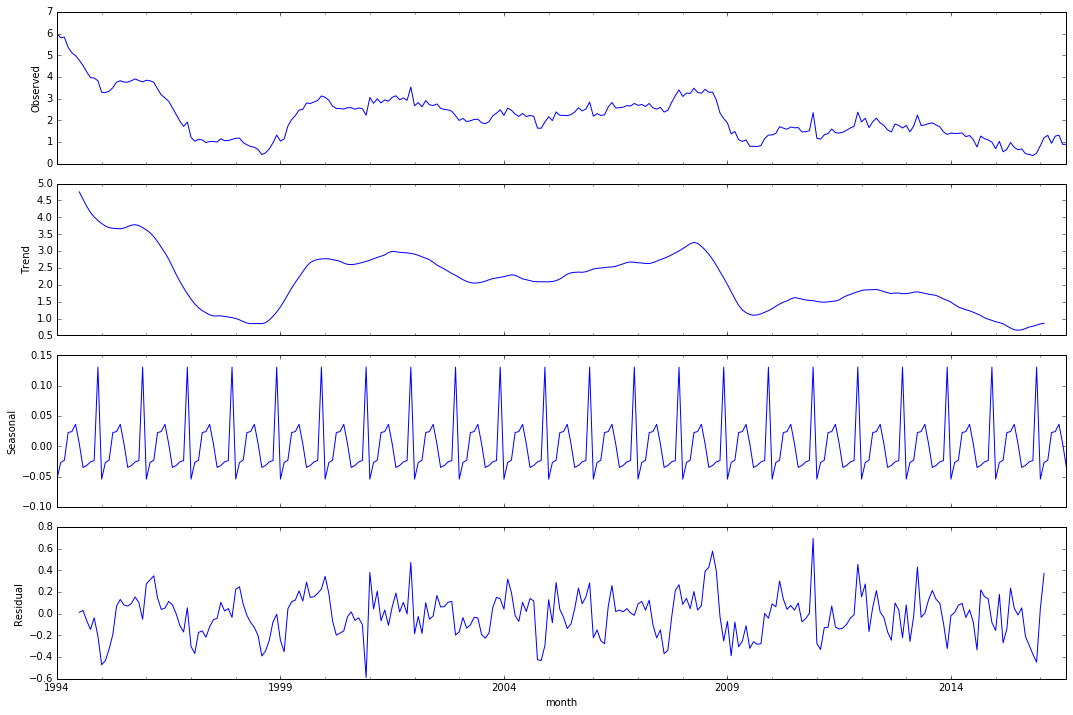

In [7]:
wages['wages_box_diff'] = wages.wages_box - wages.wages_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.wages_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages_box_diff[12:])[1])

### Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. 

## Теперь добавим ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


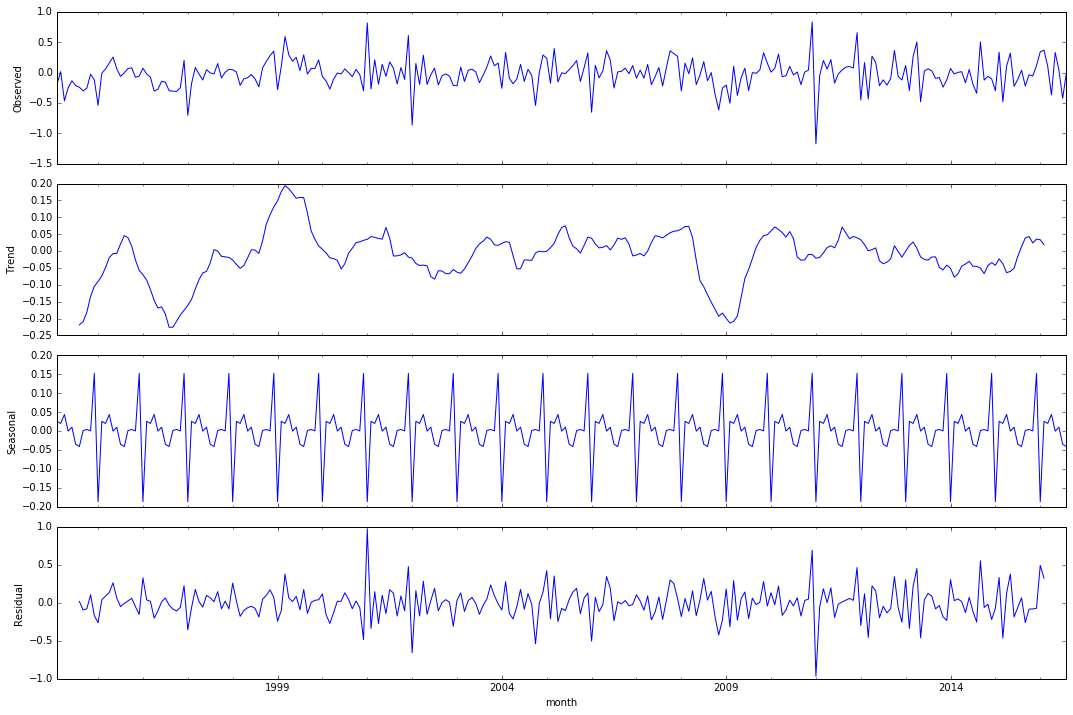

In [8]:
wages['wages_box_diff2'] = wages.wages_box_diff - wages.wages_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.wages_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages_box_diff2[13:])[1])

## Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

## Подбор модели

## Посмотрим на ACF и PACF полученного ряда:

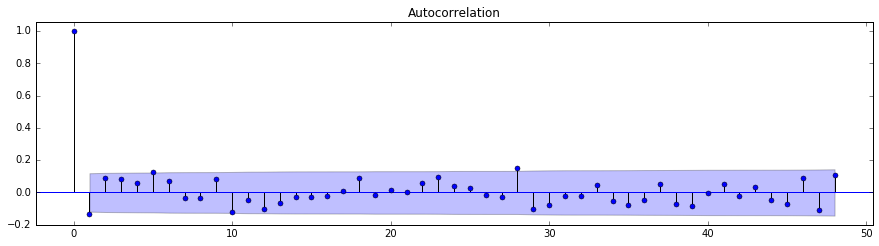

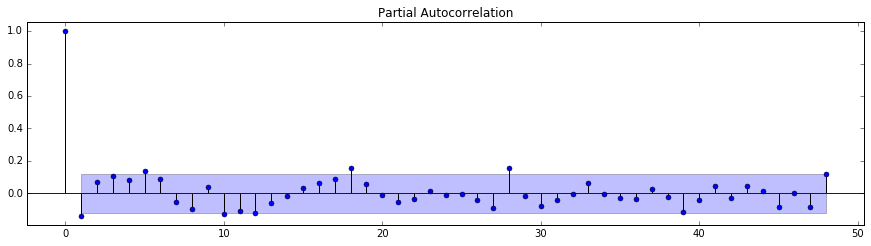

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wages.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wages.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=1, p=5

In [10]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wages.wages_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 0, 1))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 1, 1))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 0, 1))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 2, 1, 1))
Wall time: 20.1 s


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
29  (3, 1, 1, 0) -4.995859
28  (3, 1, 0, 1) -4.342768
30  (3, 1, 1, 1) -4.312789
37  (4, 1, 1, 0) -3.975974
36  (4, 1, 0, 1) -3.362304


## Лучшая модель:

In [14]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          wages_box   No. Observations:                  284
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 12)   Log Likelihood                   8.498
Date:                            Thu, 27 Apr 2017   AIC                             -4.996
Time:                                    23:49:21   BIC                             16.898
Sample:                                01-01-1993   HQIC                             3.782
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4853      0.210      2.312      0.021       0.074       0.897
ar.L2          0.1630      0.075   

## Её остатки:

Критерий Стьюдента: p=0.281820
Критерий Дики-Фуллера: p=0.000000


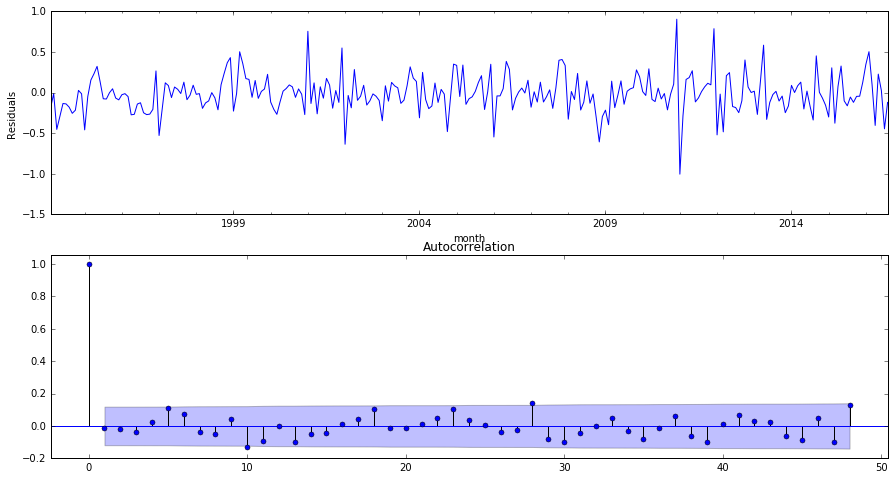

In [15]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

## Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Модель описывает данные хорошо:

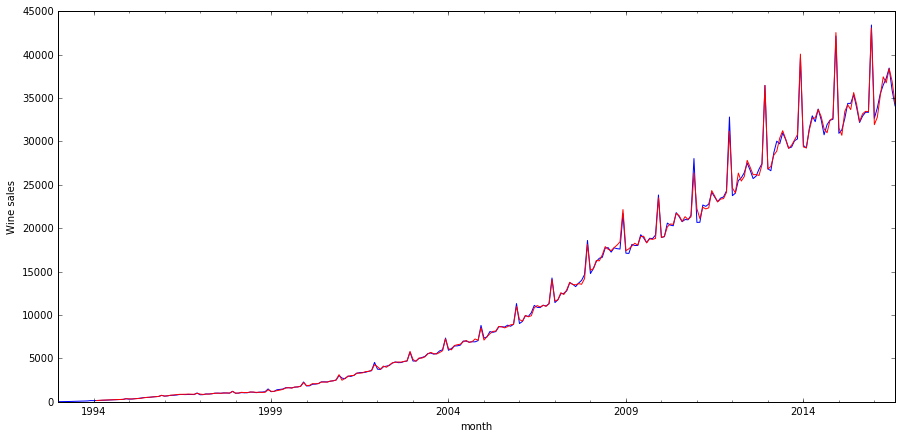

In [16]:
wages['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wages.WAG_C_M.plot()
wages.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

## Прогноз:

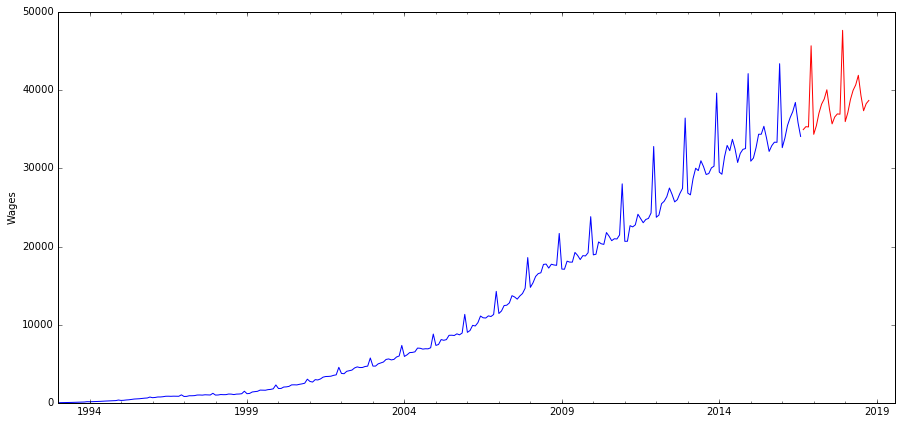

In [17]:
wages2 = wages[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wages2.columns)
wages2 = pd.concat([wages2, future])
wages2['forecast'] = invboxcox(best_model.predict(start=284, end=309), lmbda)

plt.figure(figsize(15,7))
wages2.WAG_C_M.plot()
wages2.forecast.plot(color='r')
plt.ylabel('Wages')
pylab.show()